In [1]:
import random
import pandas as pd
import numpy as np
import igraph as ig
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
#The graph is made of 203,769 nodes and 234,355 edges. Two percent (4,545) of the nodes are 
# labelled class1 (illicit).
#Twenty-one percent (42,019) are labelled class2 (licit). 
#The remaining transactions are not labelled with regard to licit versus illicit.
classes_path = "../elliptic_bitcoin_dataset/elliptic_txs_classes.csv"
edges_path = "../elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv"
features_path = "../elliptic_bitcoin_dataset/elliptic_txs_features.csv"

classes = pd.read_csv(classes_path)
edges = pd.read_csv(edges_path)
feat_cols = ['txId', 'time_step'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
feats = pd.read_csv(features_path, header=None, names=feat_cols)
classes.columns = ['txId', 'label']
df = classes.set_index('txId').join(feats.set_index('txId'))

In [3]:
label_colors = {'1':'red', '2':'green', 'unknown':'gray'}

tx_graph = ig.Graph(directed=True)

edges_dict = {tx_id: i for i, tx_id in enumerate(classes['txId'])}

tx_graph.add_vertices(len(classes))
tx_graph.vs['id'] = list(classes['txId'])
tx_graph.vs['type'] = list(classes['label'])
tx_graph.vs['time_step'] = list(feats['time_step'])
tx_graph.vs['color'] = [label_colors[label] for label in classes['label']]

edges_list = [(edges_dict[edges['txId1'][i]], edges_dict[edges['txId2'][i]]) for i in tqdm(range(len(edges)))]
tx_graph.add_edges(edges_list)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 234355/234355 [00:00<00:00, 380887.84it/s]


In [4]:
betweenness = tx_graph.betweenness(directed=True)
df.insert(1, 'betweenness', betweenness, True)

centralities = tx_graph.closeness()
df.insert(1, 'closeness', centralities, True)

in_degree = tx_graph.degree(mode="in")
df.insert(1, 'in-degree', in_degree)

out_degree = tx_graph.degree(mode='out')
df.insert(1, 'out-degree', out_degree)

clustering_coeff = tx_graph.transitivity_local_undirected(mode='zero')
df.insert(1, 'clustering_coeff', clustering_coeff)

pagerank_scores = tx_graph.pagerank(directed=True)
df.insert(1, 'pagerank', pagerank_scores, True)

In [8]:
with open('../data/Shortest paths with one random sample for every node.txt', 'r') as file:
    lines = file.readlines()

shortest_paths = [float(line.strip()) for line in lines]
df.insert(1, 'avg_shortest_paths', shortest_paths, True)

In [9]:
df.head()

,label,avg_shortest_paths,pagerank,clustering_coeff,out-degree,in-degree,closeness,betweenness,time_step,trans_feat_0,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
txId,,,,,,,,,,,,,,,,,,,,,
230425980,unknown,10.560976,0.000004,0.000000,1,1,0.092392,14.000000,1,-0.171469,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
5530458,unknown,11.486842,0.000005,0.000000,1,1,0.084580,8.000000,1,-0.171484,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
232022460,unknown,7.410526,0.000005,0.000000,2,1,0.134507,30.000000,1,-0.172107,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
232438397,2,6.857143,0.000297,0.000621,1,160,0.155365,2355.000000,1,0.163054,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
230460314,unknown,9.661290,0.000002,0.266667,8,2,0.100978,16.752381,1,1.011523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [10]:
df.shape

(203769, 174)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [15]:
#Transform the dataframe in a suitable input for KMeans. We drop the columns containing
#the correct labels
df.drop(df[df["label"] == "unknown"].index, inplace=True)

y = df['label']
X = df.drop(columns=['label'])
#X = X.loc[:, 'time_step':]
X.head()

,avg_shortest_paths,pagerank,clustering_coeff,out-degree,in-degree,closeness,betweenness,time_step,trans_feat_0,trans_feat_1,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
txId,,,,,,,,,,,,,,,,,,,,,
232438397,6.857143,0.000297,0.000621,1,160,0.155365,2355.0,1,0.163054,1.963790,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
232029206,6.771084,0.000076,0.001130,1,59,0.134193,1223.0,1,-0.005027,0.578941,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
232344069,10.216216,0.000002,0.000000,2,0,0.099405,0.0,1,-0.147852,-0.184668,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
27553029,8.028169,0.000002,0.000000,1,1,0.110372,7.0,1,-0.151357,-0.184668,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3881097,6.848485,0.000002,0.000000,1,1,0.139805,4.0,1,-0.172306,-0.184668,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


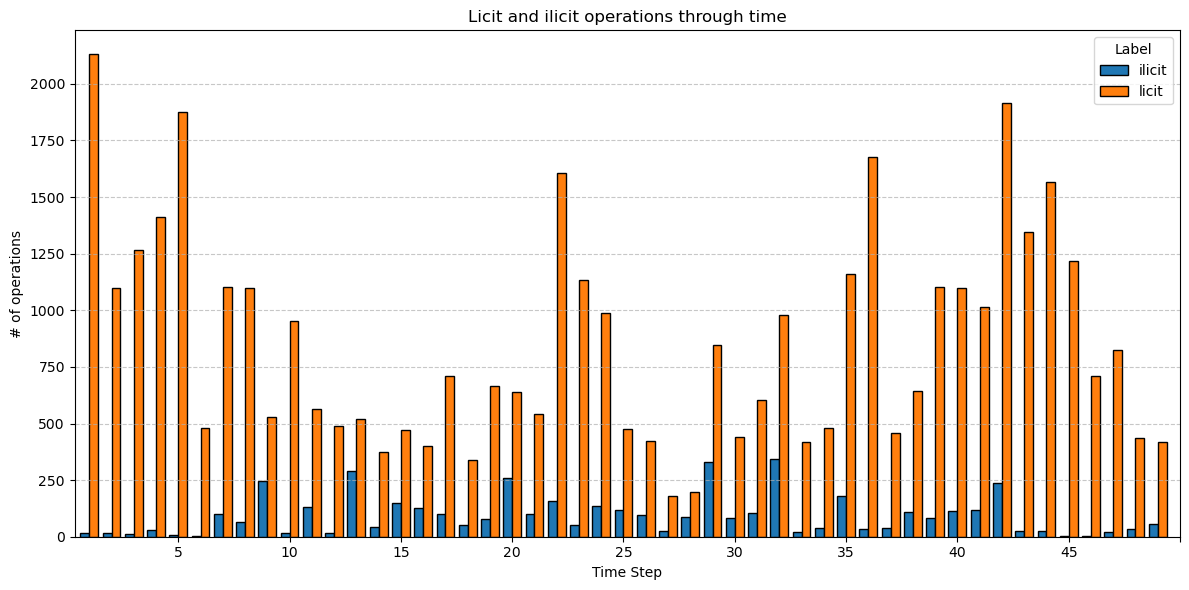

In [41]:
time_steps = X['time_step']

grouped_data = df.groupby(['time_step', 'label']).size().unstack(fill_value=0)
grouped_data.plot(kind='bar', figsize=(12, 6), width=0.8, edgecolor='black')

plt.title('Licit and ilicit operations through time')
plt.xlabel('Time Step')
plt.ylabel('# of operations')
plt.xticks(range(4, 50, 5), rotation=0)
plt.legend(title='Label', labels=['ilicit', 'licit'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [47]:
from sklearn.utils import shuffle

X_train = X[X['time_step'].between(1, 34)]
y_train = y[X['time_step'].between(1, 34)]

X_test = X[X['time_step'].between(25, 49)]
y_test = y[X['time_step'].between(25, 49)]

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [49]:
X_train.head()

,avg_shortest_paths,pagerank,clustering_coeff,out-degree,in-degree,closeness,betweenness,time_step,trans_feat_0,trans_feat_1,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,9.025000,0.000008,0.0,1,3,0.104874,8.0,5,-0.165325,-0.184668,...,-0.412695,-0.449620,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,16.352941,0.000005,0.0,1,2,0.067305,4.0,18,-0.162396,-0.158783,...,-0.569626,-0.607306,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399
2,14.098361,0.000005,0.0,1,1,0.075665,10.0,7,-0.170666,-0.184668,...,0.386911,0.212660,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3,15.133333,0.000002,0.0,1,0,0.078080,0.0,19,0.196415,-0.132897,...,-0.308073,-0.386546,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
4,11.108108,0.000002,0.0,0,1,0.087579,0.0,21,-0.172433,-0.167149,...,-0.577099,-0.500080,0.241128,0.241406,0.486952,-0.010592,-0.131155,0.247064,-0.120613,-0.119792


In [58]:
print(X_train.shape)
print(X_test.shape)

(29894, 173)
(22958, 173)


In [50]:
clf = RandomForestClassifier(n_estimators = 100)  
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [51]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
print("Cross-validated accuracy:", scores.mean())

Cross-validated accuracy: 0.982067207443462


In [52]:
from sklearn import metrics  
from sklearn.metrics import confusion_matrix

print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

ACCURACY OF THE MODEL: 0.9847547695792317


array([[ 2025,   301],
       [   49, 20583]])

In [53]:
import pandas as pd

importances = clf.feature_importances_
features = X.columns  

feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
top_features = feature_importances.head(50)

print(top_features)


           Feature  Importance
54   trans_feat_46    0.049765
62   trans_feat_54    0.044020
60   trans_feat_52    0.041243
139    agg_feat_38    0.040705
48   trans_feat_40    0.038081
12    trans_feat_4    0.037143
50   trans_feat_42    0.036911
21   trans_feat_13    0.034107
97   trans_feat_89    0.029719
56   trans_feat_48    0.026562
170    agg_feat_69    0.023698
145    agg_feat_44    0.019698
53   trans_feat_45    0.019304
25   trans_feat_17    0.018994
83   trans_feat_75    0.016665
59   trans_feat_51    0.015368
9     trans_feat_1    0.014910
149    agg_feat_48    0.014432
6      betweenness    0.012763
161    agg_feat_60    0.012511
38   trans_feat_30    0.012234
84   trans_feat_76    0.011988
151    agg_feat_50    0.011460
47   trans_feat_39    0.011314
91   trans_feat_83    0.010758
30   trans_feat_22    0.010307
32   trans_feat_24    0.010197
73   trans_feat_65    0.010183
66   trans_feat_58    0.010126
74   trans_feat_66    0.009500
68   trans_feat_60    0.009208
61   tra

# Graph visualization

In [ ]:
#import matplotlib.pyplot as plt
#fig, ax = plt.subplots(figsize=(20, 20)) 
#node_sizes = [c * 50 for c in centralities]
#layout = tx_graph.layout_fruchterman_reingold()
#ig.plot(tx_graph, vertex_size=node_sizes, vertex_frame_width=0.5, edge_width=0.1, bbox=(8000, 8000), margin=50, target=ax)
#plt.savefig("large_graph.png", dpi=300)
#plt.savefig("large_graph.pdf", dpi=600)

In [71]:
#import matplotlib.pyplot as plt

#undirected_graph = tx_graph.as_undirected(combine_edges=None)
#ilicit_indices = [v.index for v in undirected_graph.vs if v['type'] == '1']
#ilicit_graph = undirected_graph.induced_subgraph(ilicit_indices)

#fig, ax = plt.subplots(figsize=(20, 20)) 
#ilicit_centralities = ilicit_graph.closeness()
#node_sizes = [c * 50 for c in centralities]
#layout = ilicit_graph.layout_fruchterman_reingold()
#ig.plot(ilicit_graph, vertex_size=node_sizes, vertex_frame_width=0.5, edge_width=0.1, bbox=(8000, 8000), margin=50, target=ax)
#plt.savefig("ilicit_graph.pdf", dpi=300)